In [4]:
# type: ignore

import requests
import numpy as np
import os
import django
import pandas as pd 

import statsmodels.formula.api as smf

pd.set_option('display.precision', 2)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "water.settings.dev")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
_ = django.setup()

from water.utils import data
from water.models import ReservoirState, Reservoir, ReservoirStateSerializer, RainFall

In [52]:
num_obs = 10000

start_date = '2011-01-01'
end_date = '2023-01-10'
is_first_of_year = True

reservoir_uuids = [str(reservoir.uuid) for reservoir in Reservoir.objects.all()]
# Format as comma separated list
reservoir_uuids = ','.join(reservoir_uuids)

args = {
    'num_obs': num_obs,
    'start_date': start_date,
    'end_date': end_date,
    'is_first_of_year': is_first_of_year,
    'reservoir_uuids': reservoir_uuids
}

res = data.get_wide_data(**args)
df = pd.DataFrame(res)

In [53]:
rainfall_fields = RainFall._meta.get_fields()
for field in rainfall_fields:
    df[field.name] = df['rainfall'].apply(lambda x: getattr(x, field.name))
    
reservoir_state_fields = ReservoirState._meta.get_fields()
for field in reservoir_state_fields:
    df[field.name] = df['reservoir_state'].apply(lambda x: getattr(x, field.name))
    
reservoir_fields = Reservoir._meta.get_fields()
for field in reservoir_fields:
    df[field.name] = df['reservoir'].apply(lambda x: getattr(x, field.name))

df = df.sort_values(['name', 'date'])  

In [59]:
df['rainfall_rel'] = df.amount_cumulative / df.amount_cumulative_historical
df['volume_lag'] = df.groupby('name').volume.shift()
df['volume_diff'] = df.volume - df.volume_lag
df['volume_diff_rel'] = df.volume_diff / df.capacity

<Axes: xlabel='rainfall_rel', ylabel='volume_diff_rel'>

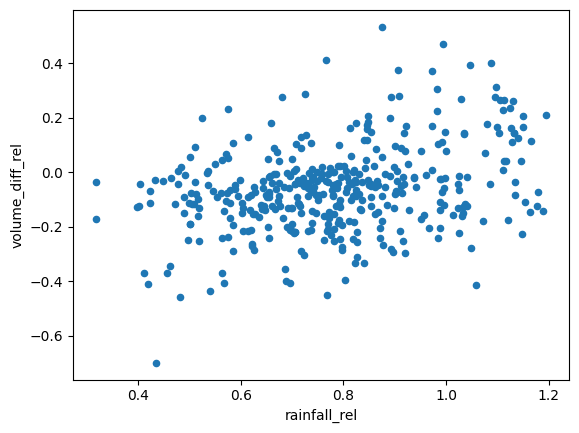

In [60]:
(df
 .query('0.3 <= rainfall_rel <= 1.2')
 [['rainfall_rel', 'volume_diff_rel']]
 .plot.scatter(x='rainfall_rel', y='volume_diff_rel'))

In [61]:
df_reg = df.copy()

form = 'volume_diff_rel ~ rainfall_rel'
model = smf.ols(formula=form, data=df_reg).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        volume_diff_rel   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     205.7
Date:                Sat, 06 Apr 2024   Prob (F-statistic):           5.35e-39
Time:                        15:37:46   Log-Likelihood:                 208.57
No. Observations:                 475   AIC:                            -413.1
Df Residuals:                     473   BIC:                            -404.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2941      0.020    -14.352   

In [58]:
coef = model.params['rainfall_rel']
coef

0.309710090851932